
θ = 65°, L_t = 10.1668, Offset = 4.4416, Nx = 300, Ny = 300
Interior nodes: 68328

Smallest 8 k² eigenvalues:
  Mode 1: k² = 0.159190
  Mode 2: k² = 0.304713
  Mode 3: k² = 0.474434
  Mode 4: k² = 0.546801
  Mode 5: k² = 0.630703
  Mode 6: k² = 0.847967
  Mode 7: k² = 0.875463
  Mode 8: k² = 1.042542


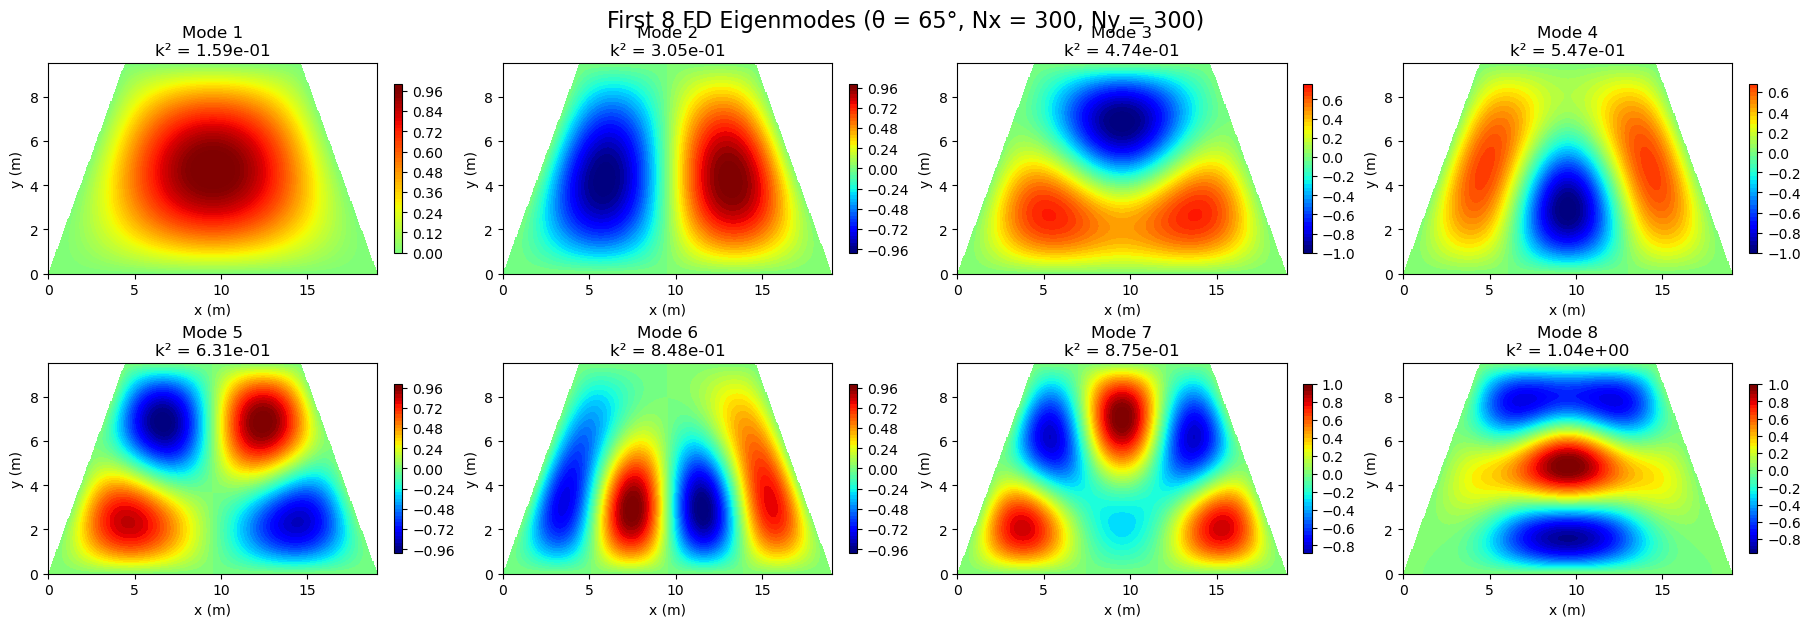


θ = 70°, L_t = 12.1164, Offset = 3.4668, Nx = 300, Ny = 300
Interior nodes: 72874

Smallest 8 k² eigenvalues:
  Mode 1: k² = 0.151439
  Mode 2: k² = 0.277115
  Mode 3: k² = 0.460059
  Mode 4: k² = 0.499297
  Mode 5: k² = 0.599200
  Mode 6: k² = 0.765964
  Mode 7: k² = 0.810922
  Mode 8: k² = 1.025621


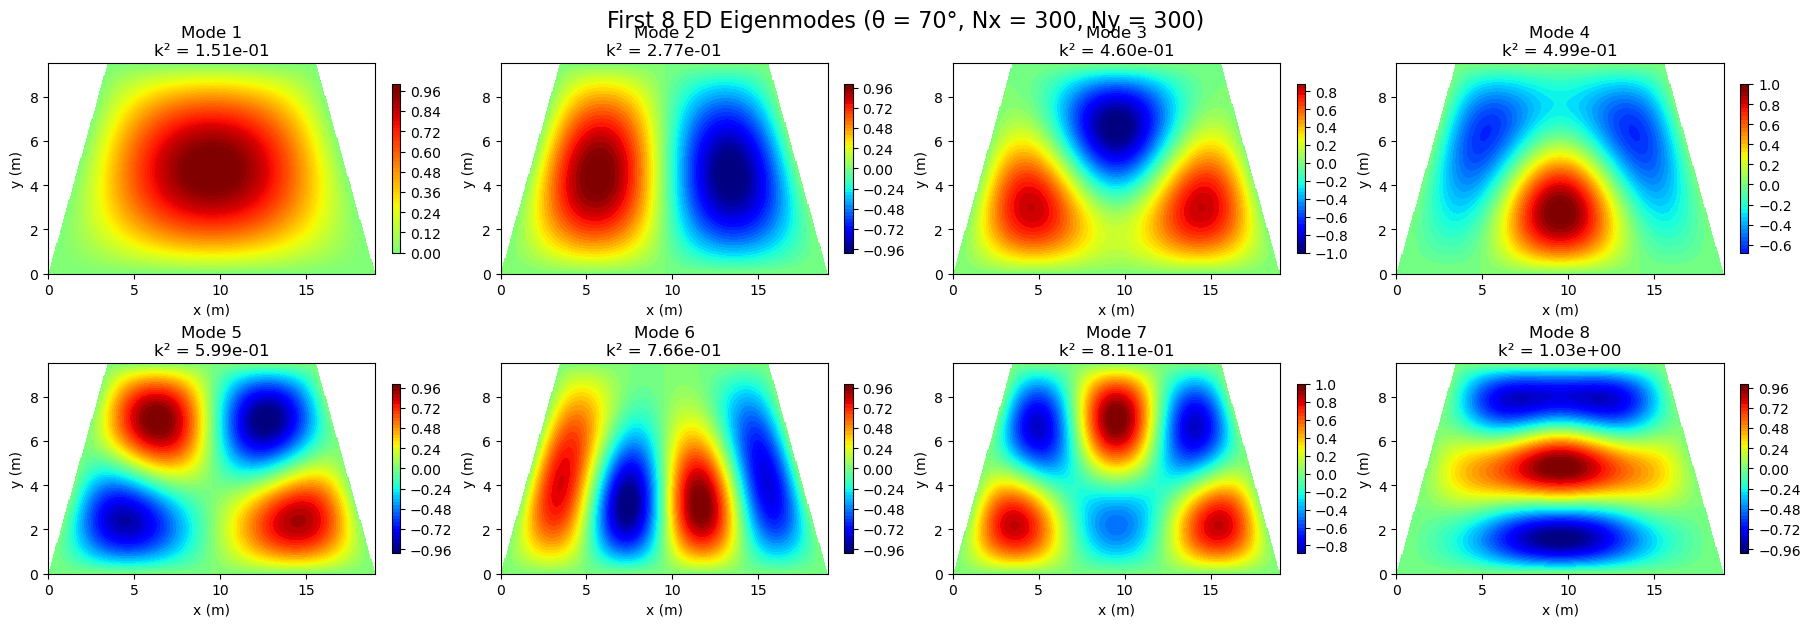


θ = 75°, L_t = 13.9456, Offset = 2.5522, Nx = 300, Ny = 300
Interior nodes: 77164

Smallest 8 k² eigenvalues:
  Mode 1: k² = 0.145869
  Mode 2: k² = 0.256249
  Mode 3: k² = 0.433645
  Mode 4: k² = 0.476802
  Mode 5: k² = 0.578149
  Mode 6: k² = 0.694886
  Mode 7: k² = 0.763604
  Mode 8: k² = 1.010871


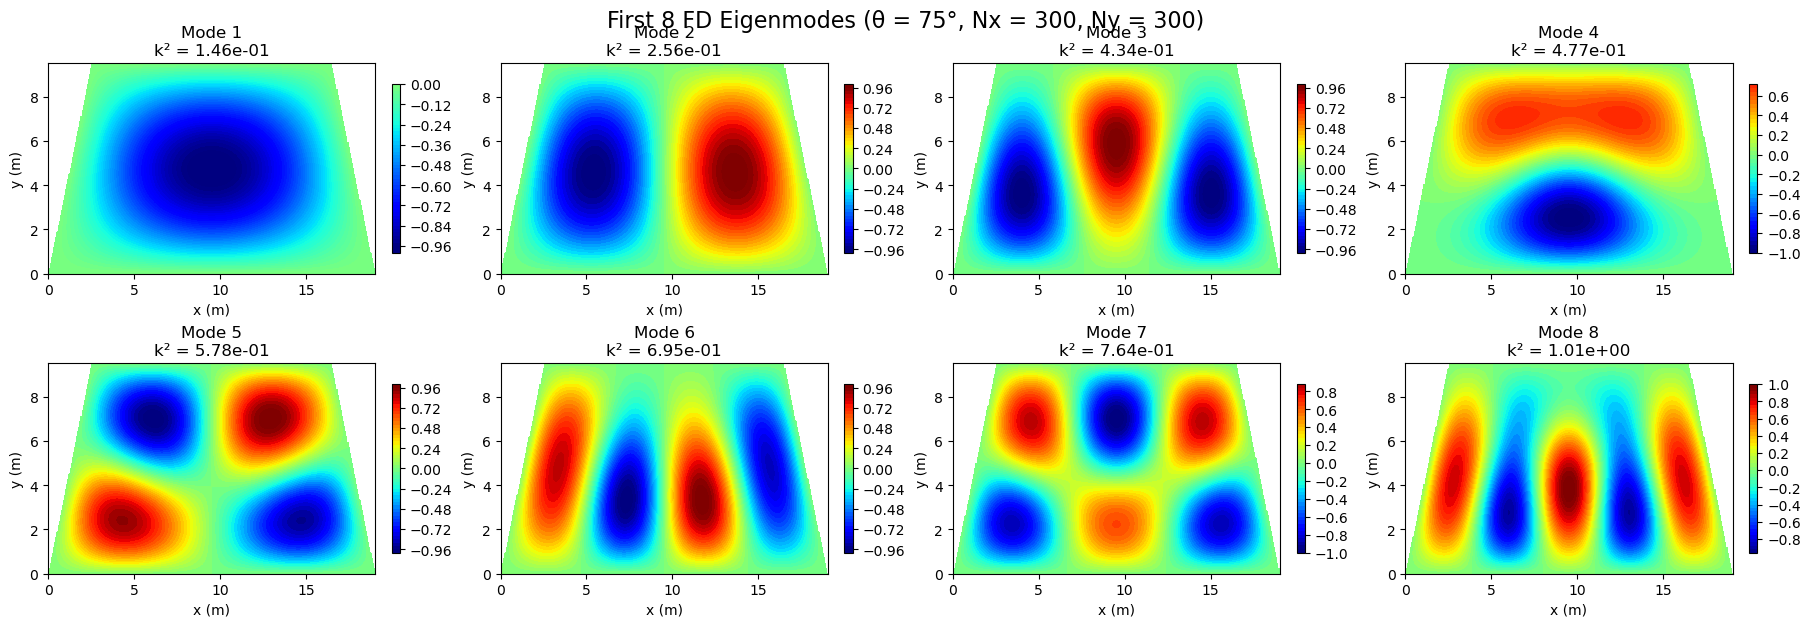


θ = 80°, L_t = 15.6910, Offset = 1.6795, Nx = 300, Ny = 300
Interior nodes: 81246

Smallest 8 k² eigenvalues:
  Mode 1: k² = 0.141690
  Mode 2: k² = 0.240126
  Mode 3: k² = 0.402563
  Mode 4: k² = 0.468999
  Mode 5: k² = 0.563194
  Mode 6: k² = 0.634727
  Mode 7: k² = 0.728481
  Mode 8: k² = 0.924326


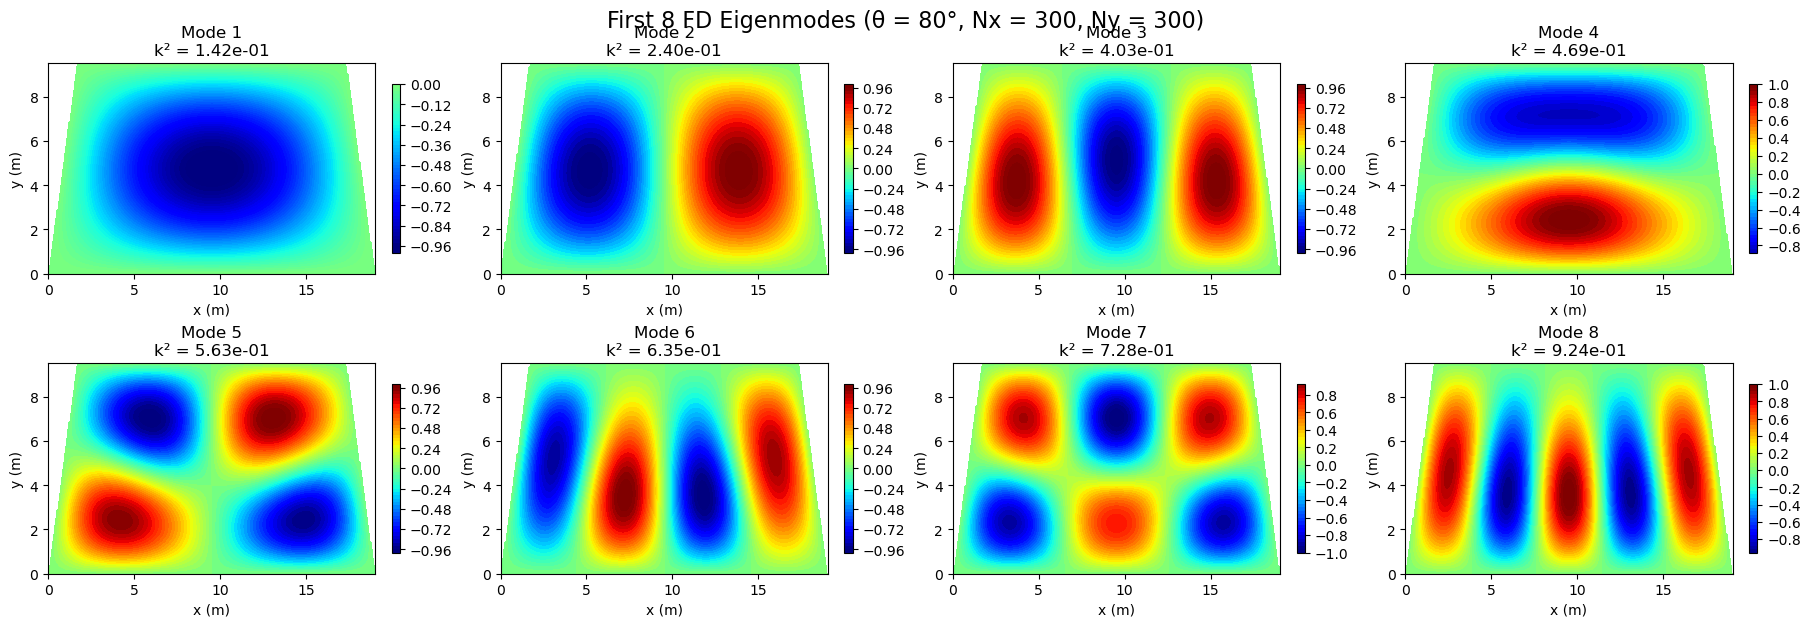


θ = 85°, L_t = 17.3833, Offset = 0.8333, Nx = 300, Ny = 300
Interior nodes: 85204

Smallest 8 k² eigenvalues:
  Mode 1: k² = 0.138432
  Mode 2: k² = 0.227318
  Mode 3: k² = 0.375185
  Mode 4: k² = 0.464915
  Mode 5: k² = 0.551959
  Mode 6: k² = 0.584071
  Mode 7: k² = 0.701111
  Mode 8: k² = 0.848815


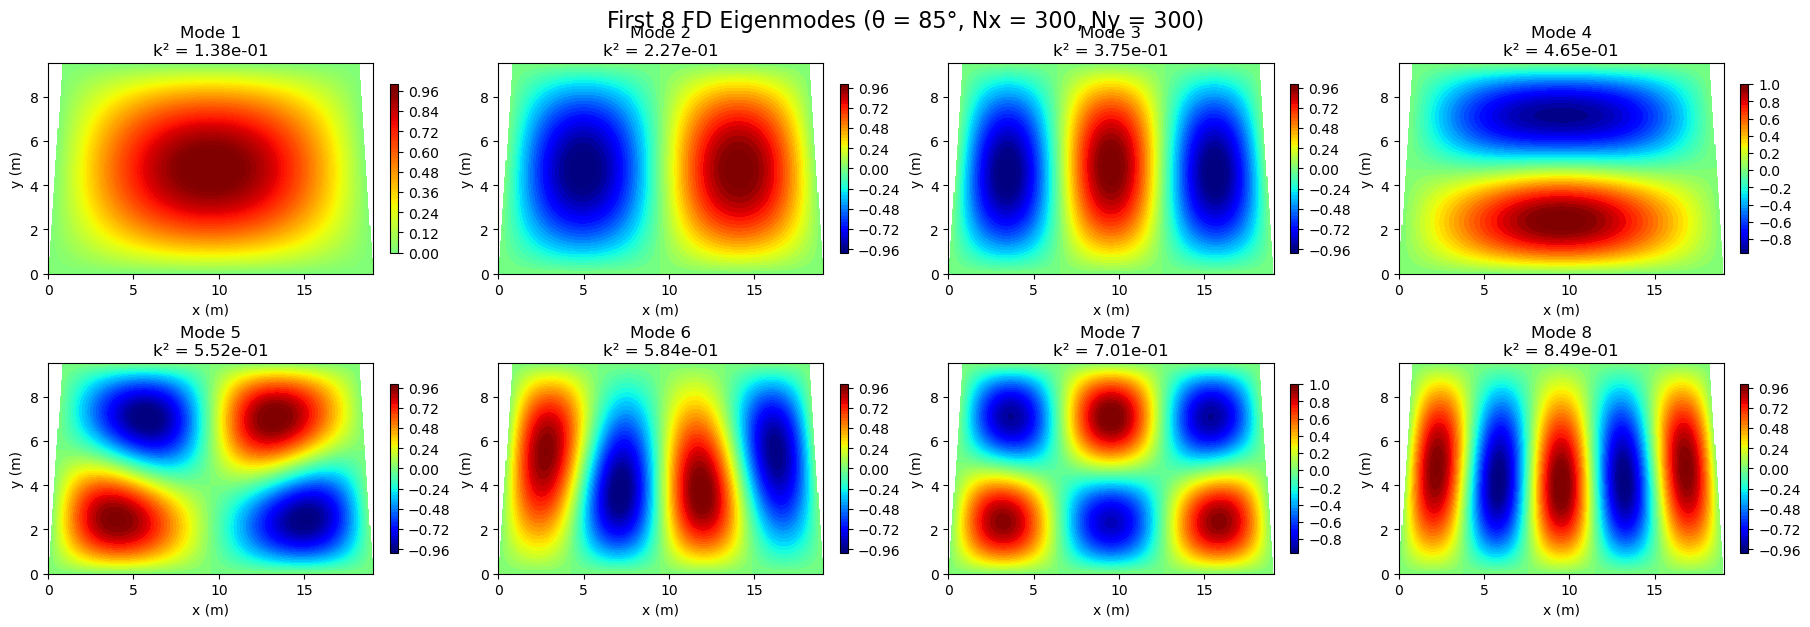


θ = 90°, L_t = 19.0500, Offset = 0.0000, Nx = 300, Ny = 300
Interior nodes: 88804

Smallest 8 k² eigenvalues:
  Mode 1: k² = 0.135980
  Mode 2: k² = 0.217565
  Mode 3: k² = 0.353531
  Mode 4: k² = 0.462321
  Mode 5: k² = 0.543861
  Mode 6: k² = 0.543906
  Mode 7: k² = 0.679871
  Mode 8: k² = 0.788535


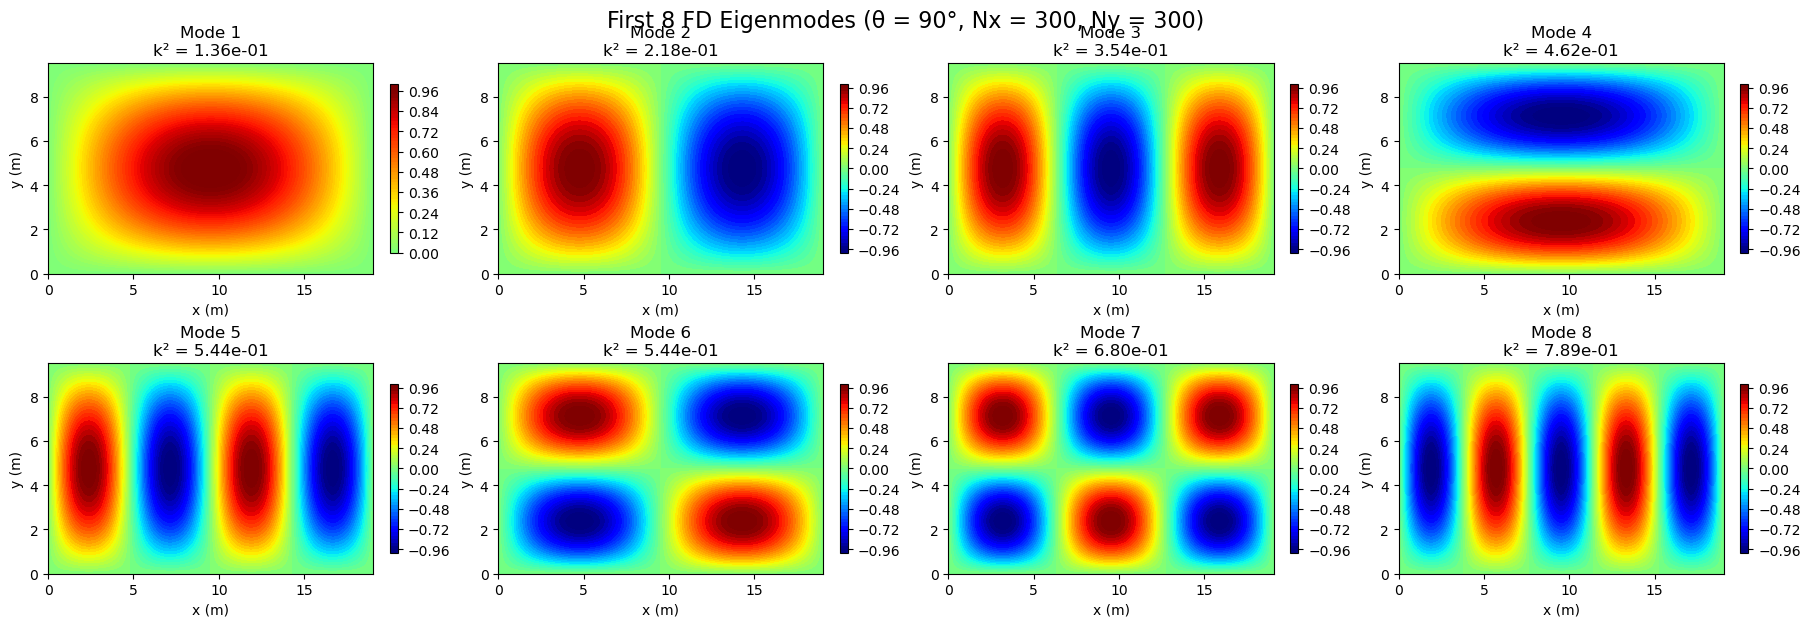

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import eigsh

def solve_trapezoidal_waveguide(theta=65.0, Nx=300, Ny=300, num_modes=20):
    # DOMAIN GEOMETRY
    Lb = 19.05  # Bottom length (m)
    Ll = 0.0
    Lr = Ll + Lb
    H = 9.525  # Height (m)

    theta_rad = np.deg2rad(theta)
    if np.isclose(theta, 90.0, atol=1e-8):
        L_t = Lb
    else:
        L_t = Lb - 2 * H / np.tan(theta_rad)
    offset = H / np.tan(theta_rad)

    print(f"\nθ = {theta}°, L_t = {L_t:.4f}, Offset = {offset:.4f}, Nx = {Nx}, Ny = {Ny}")

    def x_left(y): return Ll + offset * (y / H)
    def x_right(y): return Lr - offset * (y / H)

    x = np.linspace(Ll, Lr, Nx)
    y = np.linspace(0, H, Ny)
    X, Y = np.meshgrid(x, y)

    inside = (X >= x_left(Y)) & (X <= x_right(Y)) & (Y >= 0) & (Y <= H)
    tol = 1e-8
    interior = inside & (X > x_left(Y) + tol) & (X < x_right(Y) - tol) & (Y > tol) & (Y < H - tol)

    # Index mapping
    index_map = {}
    counter = 0
    for j in range(Ny):
        for i in range(Nx):
            if interior[j, i]:
                index_map[(i, j)] = counter
                counter += 1
    M = counter
    print(f"Interior nodes: {M}")

    hx = (Lr - Ll) / (Nx - 1)
    hy = H / (Ny - 1)

    # Finite difference matrix
    A = lil_matrix((M, M))
    for j in range(Ny):
        for i in range(Nx):
            if not interior[j, i]:
                continue
            idx = index_map[(i, j)]
            A[idx, idx] = 2.0/hx**2 + 2.0/hy**2

            if (i+1 < Nx) and interior[j, i+1]:
                A[idx, index_map[(i+1, j)]] = -1.0/hx**2
            if (i-1 >= 0) and interior[j, i-1]:
                A[idx, index_map[(i-1, j)]] = -1.0/hx**2
            if (j+1 < Ny) and interior[j+1, i]:
                A[idx, index_map[(i, j+1)]] = -1.0/hy**2
            if (j-1 >= 0) and interior[j-1, i]:
                A[idx, index_map[(i, j-1)]] = -1.0/hy**2
    A = A.tocsr()

    # Eigenvalue solve
    eigvals, eigvecs = eigsh(A, k=num_modes, which='SM')
    sorted_indices = np.argsort(eigvals)
    eigvals = eigvals[sorted_indices]
    eigvecs = eigvecs[:, sorted_indices]

    print("\nSmallest 8 k² eigenvalues:")
    for mode in range(min(8, num_modes)):
        print(f"  Mode {mode+1}: k² = {eigvals[mode]:.6f}")

    # Reconstruct eigenmodes
    modes_full = np.zeros((num_modes, Ny, Nx))
    for mode in range(num_modes):
        field = np.zeros((Ny, Nx))
        for (i, j), idx in index_map.items():
            field[j, i] = eigvecs[idx, mode]
        field /= np.max(np.abs(field))
        modes_full[mode] = field

    # Plotting
    fig, axes = plt.subplots(2, 4, figsize=(18, 6), constrained_layout=True)
    levels = 50
    for mode in range(8):
        ax = axes.flat[mode]
        field_plot = np.where(inside, modes_full[mode], np.nan)
        cp = ax.contourf(X, Y, field_plot, levels=levels, cmap='jet', vmin=-0.96, vmax=0.96)
        ax.set_title(f"Mode {mode+1}\nk² = {eigvals[mode]:.2e}")
        ax.set_xlabel("x (m)")
        ax.set_ylabel("y (m)")
        fig.colorbar(cp, ax=ax, shrink=0.8)

    plt.suptitle(f"First 8 FD Eigenmodes (θ = {theta}°, Nx = {Nx}, Ny = {Ny})", fontsize=16, y=1.02)
    plt.show()

# --- Example usage ---
solve_trapezoidal_waveguide(theta=65, Nx=300, Ny=300)
solve_trapezoidal_waveguide(theta=70, Nx=300, Ny=300)
solve_trapezoidal_waveguide(theta=75, Nx=300, Ny=300)
solve_trapezoidal_waveguide(theta=80, Nx=300, Ny=300)
solve_trapezoidal_waveguide(theta=85, Nx=300, Ny=300)
solve_trapezoidal_waveguide(theta=90, Nx=300, Ny=300)